In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap_hbb.json') as f:
  pmap = json.load(f)

#del pmap['ggF-powheg']
#del pmap['muondata']
#del pmap['data']

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [4]:
# Read in files with no selection
indir = "../outfiles/notrigger/chunksize10000_noselection/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum_nosel = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum_nosel['templates'] = out['templates']
            outsum_nosel['sumw'] = out['sumw']
            started += 1
        else:
            outsum_nosel['templates'].add(out['templates'])
            outsum_nosel['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize10000_noselection/2017_dask_z.coffea


In [5]:
# Create template out of no selection events
scale_lumi_nosel = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum_nosel['sumw'].items()}
outsum_nosel['templates'].scale(scale_lumi_nosel, 'dataset')

templates_nosel = outsum_nosel['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [6]:
# Read in files with selection
indir = "../outfiles/notrigger/chunksize100000/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum_sel = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum_sel['templates'] = out['templates']
            outsum_sel['sumw'] = out['sumw']
            started += 1
        else:
            outsum_sel['templates'].add(out['templates'])
            outsum_sel['sumw'].add(out['sumw'])
    
        del out

Loading ../outfiles/notrigger/chunksize100000/2017_dask_data.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_higgs.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_qcd.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_top.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_wandvv.coffea
Loading ../outfiles/notrigger/chunksize100000/2017_dask_z.coffea


In [7]:
# Create template out of selection events
scale_lumi_sel = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum_sel['sumw'].items()}
outsum_sel['templates'].scale(scale_lumi_sel, 'dataset')

templates_sel = outsum_sel['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

Sig. sel. eff. for msd > 105 && msd < 145

pass pt > 350: 0.557088202298999
pass pt > 450: 0.3864236720657009

Sig. sel. eff. for msd > 105 && msd < 145

fail pt > 350: 0.2588498922508424
fail pt > 450: 0.16631720680494166



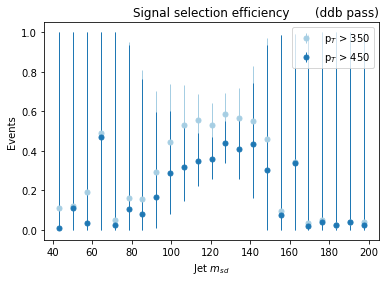

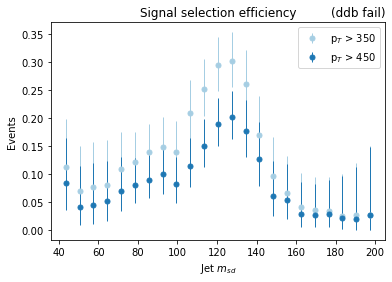

In [58]:
ddb_regions = ["pass", "fail"]

for ddb_region in ddb_regions:
    if ddb_region == 'pass':
        ddb_l = 0.64
        ddb_r = 1
    elif ddb_region == 'fail':
        ddb_l = 0
        ddb_r = 0.64

    # Histogram of signal with no selection
    h_nosel = templates_nosel['H(bb)'].integrate('region','noselection').sum('genflavor', 'pt1').integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        
    # Histogram of signal with selection (pt > 350)  
    pt_region = 350
    h_sel_pt350 = templates_sel['H(bb)'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))

    # Histogram of signal with selection (pt > 450) 
    pt_region = 450
    h_sel_pt450 = templates_sel['H(bb)'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))

    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': '#a6cee3',
            'elinewidth': 1,
        }
    
    fig, ax = plt.subplots(1, 1)
    # Plot ratio of with selection (pt > 350) and no selection
    hist.plotratio(
            num=h_sel_pt350.sum("process"),
            denom=h_nosel.sum("process"),
            clear=False,
            ax=ax,
            error_opts=data_err_opts,
            label=r'p$_{T}$ > 350'
        )
    
    data_err_opts['color'] = '#1f78b4'
    
    # Plot ratio of with selection (pt > 450) and no selection
    hist.plotratio(
            num=h_sel_pt450.sum("process"),
            denom=h_nosel.sum("process"),
            clear=False,
            ax=ax,
            error_opts=data_err_opts,
            label=r'p$_{T}$ > 450'
        )
    
    leg = ax.legend()
    ax.set_title('(ddb {0})'.format(ddb_region), loc='right')
    ax.set_title('Signal selection efficiency')
    
    # Compute signal selection efficiency in signal region (msd > 105 && msd < 145)
    sig_sel_eff_350 = h_sel_pt350.sum('process').integrate('msd1', slice(105, 145)).values()[()]
    sig_sel_eff_450 = h_sel_pt450.sum('process').integrate('msd1', slice(105, 145)).values()[()]
    sig_sel_eff_nosel = h_nosel.sum('process').integrate('msd1', slice(105, 145)).values()[()]
    
    print('Sig. sel. eff. for msd > 105 && msd < 145\n')
    print('{0} pt > 350: {1}'.format(ddb_region, sig_sel_eff_350/sig_sel_eff_nosel))
    print('{0} pt > 450: {1}\n'.format(ddb_region, sig_sel_eff_450/sig_sel_eff_nosel))
    
    fig.savefig('../plots/sig_sel_eff/Hbb_' + ddb_region + '.png')